## Task 20 - Motor Control
### Introduction to modeling and simulation of human movement
https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md

Desiree Miraldo

* Task (for Lecture 20):

Solve problemas 3 and 4 of the notebook [Optimization (Marcos Duarte)](http://nbviewer.jupyter.org/github/BMClab/bmc/blob/master/notebooks/Optimization.ipynb).

In [1]:
# import Python libraries
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sympy as sym
from sympy.plotting import plot
import pandas as pd
from IPython.display import display
from IPython.core.display import Math

## Exercises

1. Find the extrema in the function $f(x)=x^3-7.5x^2+18x-10$ analytically and determine if they are minimum or maximum.  
2. Find the minimum in the $f(x)=x^3-7.5x^2+18x-10$ using the gradient descent algorithm.  
2. Regarding the distribution problem for the elbow muscles presented in this text:  
    a. Test different initial values for the optimization.  
    b. Test other values for the elbow angle where the results are likely to change.   
    
3. In an experiment to estimate forces of the elbow flexors, through inverse dynamics it was found an elbow flexor moment of 10 Nm.  
Consider the following data for maximum force (F0), moment arm (r), and pcsa (A) of the brachialis, brachioradialis, and biceps brachii muscles: F0 (N): 1000, 250, 700; r (cm): 2, 5, 4; A (cm$^2$): 33, 8, 23, respectively (data from Robertson et al. (2013)).  
    a. Use static optimization to estimate the muscle forces.  
    b. Test the robustness of the results using different initial values for the muscle forces.  
    c. Compare the results for different cost functions.

>##### The distribution problem in biomechanics

>Using the inverse dynamics approach in biomechanics, we can determine the net force and torque acting on a joint if we know the external forces on the segments and the kinematics and inertial properties of the segments. But with this approach we are unable to determine the individual muscles forces that  created such torque, as expressed in the following equation:

>\begin{equation}
M_{total} = M_1 + M_2 + \dots + M_n = r_1F_1 + r_2F_2 + \dots + r_nF_n
\label{}
\end{equation}

>where $r_i$ is the moment arm of the force $F_i$ that generates a torque $M_i$, a parcel of the (known) total torque $M_{total}$.  

>Even if we know the moment arm of each muscle (e.g., from cadaveric data or from image analysis), the equation above has $n$ unknowns. Because there is more than one muscle that potentially created such torque, there are more unknowns than equations, and the problem is undetermined. So, the problem is how to find how the torque is distributed among the muscles of that joint.

>One solution is to consider that we (biological systems) optimize our effort in order to minimize energy expenditure, stresses on our tissues, fatigue, etc. The principle of least action, stated in the opening of this text, is an allusion that optimization might be ubiquitous in nature. With this rationale, let's solve the distribution problem in biomechanics using optimization and find the minimum force of each muscle necessary to complete a given task.

>The following cost functions have been proposed to solve the distribution problem in biomechanics:

>\begin{equation}
\begin{array}{l l}
\displaystyle\sum_{i=1}^N F_i \quad &\text{e.g., Seireg and Arkivar (1973)}
\\
\displaystyle\sum_{i=1}^N F_i^2 \quad &
\\
\displaystyle\sum_{i=1}^N \left(\dfrac{F_i}{pcsa_i}\right)^2 \quad &\text{e.g., Crowninshield and Brand (1981)}
\\
\displaystyle\sum_{i=1}^N \left(\dfrac{F_i}{M_{max,i}}\right)^3 \quad &\text{e.g., Herzog (1987)}
\end{array}
\label{}
\end{equation}

>Where $pcsa_i$ is the physiological cross-sectional area of muscle $i$ and $M_{max,i}$ is the maximum torque muscle $i$ can produce.  
Each muscle force $F_i$ is a design variable and the following constraints must be satisfied:

>\begin{equation}
\begin{array}{l l}
0 \leq F_i \leq F_{max}
\\
\displaystyle\sum_{i=1}^N r_i \times F_i = M
\end{array}
\label{}
\end{equation}

>Let's apply this concept to solve a distribution problem in biomechanics.

>##### Muscle force estimation

>Consider the following main flexors of the elbow joint (see figure below): biceps long head, biceps short head, and brachialis. Suppose that the elbow net joint torque determined using inverse dynamics is 20 Nm (flexor). How much each of these muscles contributed to the net torque?

><div class='center-align'><figure><img src='./filesLecture20/elbowflexors.png' alt='Elbow flexors'/> <figcaption><center><i>Figure. A view in OpenSim of the arm26 model showing three elbow flexors (Biceps long and short heads and Brachialis).</i></center></figcaption> </figure></div>

>For the optimization, we will need experimental data for the moment arm, maximum moment, and *pcsa* of each muscle. Let's import these data from the OpenSim arm26 model:


In [2]:
# time elbow_flexion BIClong BICshort BRA
r_ef = np.loadtxt('./filesLecture20/r_elbowflexors.mot', skiprows=7)
f_ef = np.loadtxt('./filesLecture20/f_elbowflexors.mot', skiprows=7)

>The maximum isometric force of these muscles are defined in the arm26 model as: Biceps long head: 624.3 N, Biceps short head: 435.56 N, and Brachialis: 987.26 N. Let's compute the mamimum torques that each muscle could produce considering a static situation at the different elbow flexion angles:

In [3]:
m_ef = r_ef*1
m_ef[:, 2:] = r_ef[:, 2:]*f_ef[:, 2:]

>And let's visualize these data:

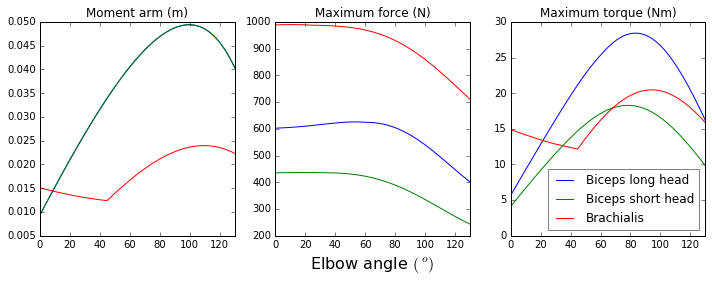

In [4]:
labels = ['Biceps long head', 'Biceps short head', 'Brachialis']
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(10, 4))
ax[0].plot(r_ef[:, 1], r_ef[:, 2:])
#ax[0].set_xlabel('Elbow angle $(\,^o)$')
ax[0].set_title('Moment arm (m)')
ax[1].plot(f_ef[:, 1], f_ef[:, 2:])
ax[1].set_xlabel('Elbow angle $(\,^o)$', fontsize=16)
ax[1].set_title('Maximum force (N)')
ax[2].plot(m_ef[:, 1], m_ef[:, 2:])
#ax[2].set_xlabel('Elbow angle $(\,^o)$')
ax[2].set_title('Maximum torque (Nm)')
ax[2].legend(labels, loc='best', framealpha=.5)
ax[2].set_xlim(np.min(r_ef[:, 1]), np.max(r_ef[:, 1]))
plt.tight_layout()
plt.show()

>These data don't have the *pcsa* value of each muscle. We will estimate the *pcsa* considering that the amount of maximum muscle force generated per area is constant and equal to 50N/cm$^2$. Consequently, the *pcsa* (in cm$^2$) for each muscle is:

In [5]:
a_ef = np.array([624.3, 435.56, 987.26])/50  # 50 N/cm2
print(a_ef)

[ 12.486    8.7112  19.7452]


>##### Static versus dynamic optimization

>In the context of biomechanics, we can solve the distribution problem separately for each angle (instant) of the elbow; we will refer to that as static optimization. However, there is no guarantee that when we analyze all these solutions across the range of angles, they will be the best solution overall. One reason is that static optimization ignores the time history of the muscle force. Dynamic optimization refers to the optimization over a period of time. For such, we will need to input a cost function spanning the entire period of time at once. Dynamic optimization usually has a higher computational cost than static optimization. The term 'Dynamic optimization' used in Biomechanics is not related to the broader method known as '[dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming)' in mathematical optimization or computer programming.

><div class='center-align'><figure><img src='./filesLecture20/optim_stat_dyn.png' width=550 alt='static versus dynamic optimization' vspace="10"/> <figcaption><center><i>Figure. Static and dynamic optimization approaches in Biomechanics. Figure taken from Robertson et al. (2013).</i></center></figcaption> </figure></div>

>The title 'Static and dynamic optimization solutions for gait are practically equivalent' of an article published by Anderson and Pandy (2001), where they studied normal walking (full gait cycle equals to 1.12 s), summarizes the results of such comparison. The authors reported that the dynamic solution required 1000 times more computation time than the static solution.

>For now, we will solve the present problem using static optimization.

>##### Solution of the optimization problem

>For the present case, we are dealing with a problem of minimization, multidimensional (function of several variables), nonlinear, constrained, and we can't assume that the cost function is convex. Numerical optimization is hardly a simple task. There are many different algorithms and public and commercial software for performing optimization. For instance, look at [NEOS Server](http://www.neos-server.org/neos/), a free internet-based service for solving numerical optimization problems.  
We will solve the present problem using the [scipy.optimize](http://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize) package which provides several optimization algorithms. We will use the function `minimize`:

>```python
scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
"""Minimization of scalar function of one or more variables."""
```

>Now, let's write Python functions for each cost function:

In [6]:
from scipy.optimize import minimize

In [7]:
def cf_f1(x):
    """Cost function: sum of forces."""  
    return x[0] + x[1] + x[2]

def cf_f2(x):
    """Cost function: sum of forces squared."""
    return x[0]**2 + x[1]**2 + x[2]**2

def cf_fpcsa2(x, a):
    """Cost function: sum of squared muscle stresses."""
    return (x[0]/a[0])**2 + (x[1]/a[1])**2 + (x[2]/a[2])**2

def cf_fmmax3(x, m):
    """Cost function: sum of cubic forces normalized by moments."""
    return (x[0]/m[0])**3 + (x[1]/m[1])**3 + (x[2]/m[2])**3

>Let's also define the Jacobian for each cost function (which is an optional parameter for the optimization):

In [8]:
def cf_f1d(x):
    """Derivative of cost function: sum of forces."""
    dfdx0 = 1
    dfdx1 = 1
    dfdx2 = 1
    return np.array([dfdx0, dfdx1, dfdx2])

def cf_f2d(x):
    """Derivative of cost function: sum of forces squared."""
    dfdx0 = 2*x[0]
    dfdx1 = 2*x[1]
    dfdx2 = 2*x[2]
    return np.array([dfdx0, dfdx1, dfdx2])

def cf_fpcsa2d(x, a):
    """Derivative of cost function: sum of squared muscle stresses."""
    dfdx0 = 2*x[0]/a[0]**2
    dfdx1 = 2*x[1]/a[1]**2
    dfdx2 = 2*x[2]/a[2]**2
    return np.array([dfdx0, dfdx1, dfdx2])

def cf_fmmax3d(x, m):
    """Derivative of cost function: sum of cubic forces normalized by moments."""
    dfdx0 = 3*x[0]**2/m[0]**3
    dfdx1 = 3*x[1]**2/m[1]**3
    dfdx2 = 3*x[2]**2/m[2]**3
    return np.array([dfdx0, dfdx1, dfdx2])

>##### Let's define initial values (Exercises):

In [9]:
# ---  Exercise 3 ---

M = 30  # desired torque at the elbow
iang = 45  # which will give the closest value to 90 degrees
r  = r_ef[iang, 2:]
f0 = f_ef[iang, 2:]
a  = a_ef
m  = m_ef[iang, 2:]
x0 = f_ef[iang, 2:]/10  # far from the correct answer for the sum of torques
print('M =', M)
print('x0 =', x0)
print('r * x0 =', np.sum(r*x0))

M = 30
x0 = [ 62.49103971  42.37048694  97.05571622]
r * x0 = 5.81241788462


In [28]:
# ---  Exercise 4 ---
'''
    - F0 (N): 1000, 250, 700; 
    - r (cm): 2, 5, 4; 
    - A (cm$^2$): 33, 8, 23 
'''

M = 10  # desired torque at the elbow
iang = 68  # which will give the closest value to 90 degrees
r  = np.array([2, 5, 4])*1e-2
f0 = np.array([1000, 250, 700])
a  = np.array([33, 8, 23])
m  = r*f0
x0 = f0/10  # far from the correct answer for the sum of torques
print('M =', M)
print('x0 =', x0)
print('r * x0 =', np.sum(r*x0))

M = 10
x0 = [ 100.   25.   70.]
r * x0 = 6.05


>Inequality constraints (such as boundaries in our problem) can be entered with the parameter `bounds` to the `minimize` function:

In [29]:
bnds = ((0, f0[0]), (0, f0[1]), (0, f0[2]))

>Equality constraints (such as the sum of torques should equals the desired torque in our problem), as well as inequality constraints, can be entered with the parameter `constraints` to the `minimize` function (and we can also opt to enter the Jacobian of these constraints):

In [30]:
# use this in combination with the parameter bounds:
cons = ({'type': 'eq',
         'fun' : lambda x, r, f0, M: np.array([r[0]*x[0] + r[1]*x[1] + r[2]*x[2] - M]), 
         'jac' : lambda x, r, f0, M: np.array([r[0], r[1], r[2]]), 'args': (r, f0, M)})

In [31]:
# to enter everything as constraints:
cons = ({'type': 'eq',
         'fun' : lambda x, r, f0, M: np.array([r[0]*x[0] + r[1]*x[1] + r[2]*x[2] - M]), 
         'jac' : lambda x, r, f0, M: np.array([r[0], r[1], r[2]]), 'args': (r, f0, M)},
        {'type': 'ineq', 'fun' : lambda x, r, f0, M: f0[0]-x[0],
         'jac' : lambda x, r, f0, M: np.array([-1, 0, 0]), 'args': (r, f0, M)},
        {'type': 'ineq', 'fun' : lambda x, r, f0, M: f0[1]-x[1],
         'jac' : lambda x, r, f0, M: np.array([0, -1, 0]), 'args': (r, f0, M)},
        {'type': 'ineq', 'fun' : lambda x, r, f0, M: f0[2]-x[2],
         'jac' : lambda x, r, f0, M: np.array([0, 0, -1]), 'args': (r, f0, M)},
        {'type': 'ineq', 'fun' : lambda x, r, f0, M: x[0],
         'jac' : lambda x, r, f0, M: np.array([1, 0, 0]), 'args': (r, f0, M)},
        {'type': 'ineq', 'fun' : lambda x, r, f0, M: x[1],
         'jac' : lambda x, r, f0, M: np.array([0, 1, 0]), 'args': (r, f0, M)},
        {'type': 'ineq', 'fun' : lambda x, r, f0, M: x[2],
         'jac' : lambda x, r, f0, M: np.array([0, 0, 1]), 'args': (r, f0, M)})

>Although more verbose, if all the Jacobians of the constraints are also informed, this alternative seems better than informing bounds for the optimization process (less error in the final result and less iterations).  

>Given the characteristics of the problem, if we use the function `minimize` we are limited to the SLSQP (Sequential Least SQuares Programming) solver.  

>Finally, let's run the optimization for the four different cost functions and find the optimal muscle forces:

In [32]:
f1r = minimize(fun=cf_f1, x0=x0, args=(), jac=cf_f1d,
               constraints=cons, method='SLSQP',
               options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 200.0
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12


In [33]:
f2r = minimize(fun=cf_f2, x0=x0, args=(), jac=cf_f2d,
               constraints=cons, method='SLSQP',
               options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 22222.2222222
            Iterations: 7
            Function evaluations: 8
            Gradient evaluations: 7


In [34]:
fpcsa2r = minimize(fun=cf_fpcsa2, x0=x0, args=(a,), jac=cf_fpcsa2d,
                   constraints=cons, method='SLSQP',
                   options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 69.3481276006
            Iterations: 11
            Function evaluations: 11
            Gradient evaluations: 11


In [35]:
fmmax3r = minimize(fun=cf_fmmax3, x0=x0, args=(m,), jac=cf_fmmax3d,
                   constraints=cons, method='SLSQP',
                   options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 267.801389779
            Iterations: 13
            Function evaluations: 13
            Gradient evaluations: 13


>Let's compare the results for the different cost functions:

In [36]:
dat = np.vstack((np.around(r*100,1), np.around(a,1), np.around(f0,0), np.around(m,1)))
opt = np.around(np.vstack((f1r.x, f2r.x, fpcsa2r.x, fmmax3r.x)), 1)
er = ['-', '-', '-', '-',
      np.sum(r*f1r.x)-M, np.sum(r*f2r.x)-M, np.sum(r*fpcsa2r.x)-M, np.sum(r*fmmax3r.x)-M]
data = np.vstack((np.vstack((dat, opt)).T, er)).T

rows = ['$\text{Moment arm}\;[cm]$', '$pcsa\;[cm^2]$', '$F_{max}\;[N]$', '$M_{max}\;[Nm]$',
        '$\sum F_i$', '$\sum F_i^2$', '$\sum(F_i/pcsa_i)^2$', '$\sum(F_i/M_{max,i})^3$']
cols = ['Biceps long head', 'Biceps short head', 'Brachialis', 'Error in M']
df = pd.DataFrame(data, index=rows, columns=cols)
print('\nComparison of different cost functions for solving the distribution problem')
df


Comparison of different cost functions for solving the distribution problem


Biceps long head Biceps short head Brachialis  \
$\text{Moment arm}\;[cm]$              2.0               5.0        4.0   
$pcsa\;[cm^2]$                        33.0               8.0       23.0   
$F_{max}\;[N]$                      1000.0             250.0      700.0   
$M_{max}\;[Nm]$                       20.0              12.5       28.0   
$\sum F_i$                            -0.0             200.0       -0.0   
$\sum F_i^2$                          44.4             111.1       88.9   
$\sum(F_i/pcsa_i)^2$                 151.0              22.2      146.7   
$\sum(F_i/M_{max,i})^3$               65.5              51.1      153.3   

                                  Error in M  
$\text{Moment arm}\;[cm]$                  -  
$pcsa\;[cm^2]$                             -  
$F_{max}\;[N]$                             -  
$M_{max}\;[Nm]$                            -  
$\sum F_i$                               0.0  
$\sum F_i^2$                             0.0  
$\sum(F_i/pcsa_i)^2$                     0.0  
$\sum(F_i/M_{max,i})^3$    -1.7763568394e-15